### Import Required Libraries

In [4]:
import numpy as np
import json
import glob
import re
from pprint import pprint
from os import listdir
from os.path import isfile, join

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel

#spacy & spacy
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet') 
nltk.download('stopwords')

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# data injest
from utils import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MoRevolution\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MoRevolution\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MoRevolution\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Pre-process and vectorize the documents 

In case prompted to install stopwords, use "nltk.download(stopwords)".

In [5]:
stops = set(stopwords.words("english"))

def lemmatize(texts: str, allowed_post_tags=["NOUN", "ADJ", "VERB", "ADV", "PROPN"], accuracy = "low") :
    """
    :param texts: paragraphs
    :param allowed_post_tags: allowed parts of speech
    :param accuracy: (optional) accuracy needed from the model 
        return: 
            tokenized and lemmatized texts
    """
    if type(texts) != str: 
        raise Exception("No input string given.")
    
    if accuracy not in ["low", "high"]:
        raise Exception("In correct argument:", accuracy)
    else:
        if accuracy != "high":
            #Use "python -m spacy download en_core_web_sm" in a terminal if error [E050]
            model = spacy.load("en_core_web_sm", disable=["parser","ner"])
        else:
            #Use "python -m spacy download 'en_core_web_md'" in a terminal if error [E050]
            model = spacy.load('en_core_web_md', disable=["parser","ner"])

    model.add_pipe('sentencizer')
    sentence_generator = model(texts).sents # create a generator object for sentences in the text
    sentence_arr = []

    for sentence in sentence_generator:
        tokens = " ".join([token.lemma_ for token in sentence
                        if token.pos_ in allowed_post_tags 
                        and token not in stops
                        and not token.is_punct
                        and not token.like_num
                        and not token.is_digit
                        and not token.is_space
                        and not token.is_currency]) # checking all this takes a lot of time
        
        sentence_arr.append(tokens)
        
    return " ".join(sentence_arr)
        

In [6]:
# load data from folder with txt files
folder_path = "lowSES"
txt_files = [file for file in listdir(folder_path) if file.endswith(".txt")]

data_files = []

for txt_path in txt_files:
    txt_path = join(folder_path, txt_path)
    if isfile(txt_path):
        with open(txt_path) as f_input:
            data_files.append(f_input.read())

# lemmatize data 
data_preporcessed = [lemmatize(data) for data in data_files]

In [7]:
#deaccenting and removing stop words
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_preporcessed = gen_words(data_preporcessed)
print (data_preporcessed[0])

['lot', 'people', 'school', 'come', 'family', 'live', 'comfortably', 'however', 'poor', 'mom', 'make', 'less', 'year', 'feel', 'people', 'hear', 're', 'listen', 're', 'also', 'disadvantage', 'schooling', 'area', 'as', 'rigorous', 'la', 'bay', 'area', 'kid', 'nonetheless', 'here', 'tuition', 'room', 'board', 'expensive', 'even', 'worth', 'grant', 'scholarship', 'loan', 'pay', 'school', 'also', 'come', 'college', 'laptop', 'enough', 'money', 'book', 'hell', 'suppose', 'engineer', 'laptop', 'thing', 'need', 'suck', 'hard', 'fun', 'adventure', 'real', 'world', 'fucking', 'brutal']


In [8]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_preporcessed, min_count=2,threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_preporcessed],threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return(bigram[doc] for doc in texts)

def make_trigrams(texts): 
    return(trigram[bigram[doc]] for doc in texts)

data_bigrams = make_bigrams(data_preporcessed)
data_bigrams_trigrams = make_trigrams(data_bigrams)

data_bigrams_trigrams = list(data_bigrams_trigrams)
# print(data_bigrams_trigrams[:1])

In [9]:
#TF-IDF REMOVAL
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams
# print(texts[0][:20])

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

###  Initial Training and Evaluation

In [10]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Dont evaluate model perplexity, takes too much time

lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word,
    chunksize=chunksize,
    alpha="auto",
    eta="auto",
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [13]:
#Compute Coherence Score 
coherence_model_lda = CoherenceModel(
    model = lda_model,
    texts = texts, 
    dictionary = id2word, 
    coherence = 'c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.2860410735035415


In [14]:
# save lda model
lda_model.save("Models/Model V3 (11-24-2023)/Model V3.gensim")

#### Visualization

In [15]:
#use "pip install pyLDAvis" if the pyLDAvis library isn't installed on your system
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

c:\Users\MoRevolution\miniconda3\envs\nlpR_3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.003588  0.009477       1        1  25.411521
5      0.022052 -0.157250       2        1  19.072917
1     -0.104099 -0.042269       3        1  17.508607
4     -0.101022  0.168743       4        1   9.017139
3      0.160604 -0.113433       5        1   8.417112
7      0.106487 -0.032886       6        1   5.870263
9      0.034190  0.179919       7        1   4.546781
0     -0.097964 -0.144767       8        1   3.942429
2     -0.185178  0.039994       9        1   3.935966
8      0.168517  0.092472      10        1   2.277265, topic_info=        Term       Freq      Total Category  logprob  loglift
173       go  74.000000  74.000000  Default  30.0000  30.0000
76       job  57.000000  57.000000  Default  29.0000  29.0000
50     thing  36.000000  36.000000  Default  28.0000  28.0000
38       pay  44.000000  44.000000  Default  27.0000  27.0000
54      year  58.000000  58.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
115     food   1.033414  19.714788  Topic10  -5.2935   0.8337
158    class   1.033400  31.873360  Topic10  -5.2935   0.3533
229     mean   1.033398  12.027919  Topic10  -5.2935   1.3278
80      more   1.033375  28.718405  Topic10  -5.2935   0.4575
51   tuition   1.033363  16.999432  Topic10  -5.2935   0.9818

[712 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
210       1  0.198133  able
210       2  0.169829  able
210       3  0.283048  able
210       4  0.113219  able
210       6  0.084914  able
...     ...       ...   ...
54        2  0.221595  year
54        3  0.119321  year
54        6  0.153412  year
54        8  0.034092  year
1157      5  0.873738    yo

[1425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 2, 5, 4, 8, 10, 1, 3, 9])

### Tuning LDA Model

In [17]:
lda_model =  gensim.models.ldamodel.LdaModel.load("Models\Model V3 (11-24-2023)\Model V3.gensim")

<>:1: DeprecationWarning: invalid escape sequence \M
<>:1: DeprecationWarning: invalid escape sequence \M
C:\Users\MoRevolution\AppData\Local\Temp\ipykernel_32248\686519765.py:1: DeprecationWarning: invalid escape sequence \M
  lda_model =  gensim.models.ldamodel.LdaModel.load("Models\Model V3 (11-24-2023)\Model V3.gensim")


In [19]:
#Compute Coherence Score 
coherence_model_lda = CoherenceModel(
    model = lda_model,
    texts = texts, 
    dictionary = id2word, 
    coherence = 'c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda) # for baseline

Coherence Score:  0.2860410735035415


In [21]:
#Using a function to find the most optimal number of topics for a better coherence score. 
"""Source_1 = https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know"""
"""Source_2 = https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel"""

def compute_coherence_values(chunksize, passes, iterations, eval_every, dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
 
 -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
        corpus=corpus, 
        id2word=id2word,
        chunksize=chunksize,
        alpha="auto",
        eta="auto",
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# compute optimal number of ti
topic_list = 100
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=texts, 
    start=2, 
    limit=topic_list, 
    step=4, 
    chunksize = 2000, 
    passes = 20, 
    iterations = 400,
    eval_every = 1
)

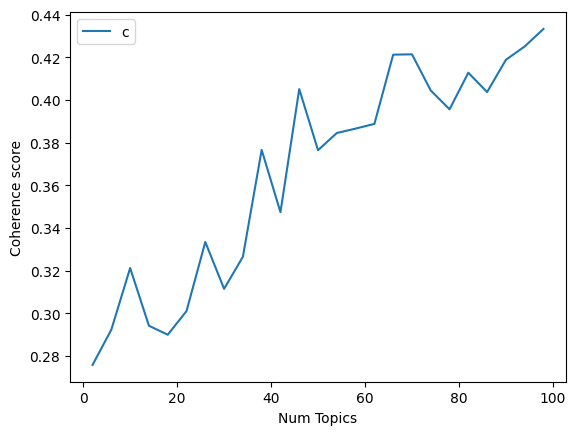

In [26]:
# Show graph
import matplotlib.pyplot as plt 
import pandas as pd

limit=topic_list; start=2; step=4
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
#Extracting the topic that gives the best results. 
best_result_model = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_model]
print(f'''{x[best_result_model]} topics give the highest coherence score of {coherence_values[best_result_model]} for this specific model''')

98 topics give the highest coherence score of 0.4332895393121243 for this specific model


In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, mds="mmds", R=30)
vis

c:\Users\MoRevolution\miniconda3\envs\nlpR_3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
32    -0.288972  0.167933       1        1  10.532523
14    -0.334056  0.187306       2        1   6.293306
57    -0.208356 -0.280249       3        1   6.282090
37    -0.320358 -0.135822       4        1   5.197136
27    -0.144181  0.397638       5        1   4.648077
...         ...       ...     ...      ...        ...
4      0.028644  0.013346      94        1   0.005895
60     0.028644  0.013346      95        1   0.005895
61     0.028644  0.013346      96        1   0.005895
63     0.028644  0.013346      97        1   0.005895
0      0.028644  0.013346      98        1   0.005895

[98 rows x 5 columns], topic_info=        Term      Freq      Total Category  logprob  loglift
46    school  80.00000  80.000000  Default  30.0000  30.0000
173       go  82.00000  82.000000  Default  29.0000  29.0000
54      year  62.00000  62.000000  Default  28.0000  28.0000
7    college  71.00000  71.000000  Default  27.0000  27.0000
76       job  63.00000  63.000000  Default  26.0000  26.0000
..       ...       ...        ...      ...      ...      ...
25       kid   0.00025  16.569377  Topic98  -7.6634  -1.3624
26        la   0.00025   1.994115  Topic98  -7.6634   0.7549
27    laptop   0.00025   3.553977  Topic98  -7.6634   0.1771
28      less   0.00025  15.861028  Topic98  -7.6634  -1.3187
29    listen   0.00025   2.065446  Topic98  -7.6634   0.7198

[5751 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
572      32  0.819836  ability
210       1  0.173138     able
210       2  0.148404     able
210       3  0.074202     able
210       5  0.049468     able
...     ...       ...      ...
715      12  0.149407    young
715      37  0.298814    young
144       6  0.750922     your
799      35  0.753754      yrs
799      44  0.376877      yrs

[4803 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[33, 15, 58, 38, 28, 44, 72, 98, 70, 7, 14, 50, 78, 30, 79, 59, 40, 32, 16, 86, 83, 92, 82, 54, 55, 20, 39, 84, 68, 12, 27, 29, 31, 45, 88, 63, 17, 22, 80, 13, 76, 60, 6, 42, 24, 4, 66, 53, 21, 85, 74, 71, 97, 3, 73, 96, 94, 75, 95, 77, 93, 91, 81, 90, 89, 87, 69, 56, 67, 65, 11, 18, 19, 23, 25, 26, 10, 9, 34, 35, 36, 37, 8, 41, 43, 46, 47, 48, 49, 2, 51, 52, 57, 5, 61, 62, 64, 1])

In [29]:
optimal_model.save("Models/Model V3 (11-24-2023)/Tuned/Model V3_tuned.gensim")

In [30]:
results = optimal_model[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in results]
print(corpus_topics)

[(59, 0.9863549), (19, 0.98769855), (43, 0.98771584), (30, 0.9922963), (19, 0.98661506), (13, 0.99215144), (32, 0.9950545), (79, 0.9895426), (29, 0.99467486), (5, 0.9833736), (11, 0.9928727), (53, 0.994919), (57, 0.99124676), (28, 0.99252254), (87, 0.98374623), (71, 0.9949362), (62, 0.9905795), (32, 0.83459616), (37, 0.99444675), (43, 0.99261695), (75, 0.9874776), (87, 0.9822261), (14, 0.9923888), (12, 0.9826301), (49, 0.99181616), (41, 0.87932986), (12, 0.9680141), (14, 0.99010855), (38, 0.9787451), (58, 0.98374426), (6, 0.6199282), (85, 0.9902241), (85, 0.9918048), (15, 0.99579036), (54, 0.99353844), (49, 0.99475574), (37, 0.9813704), (43, 0.9898517), (21, 0.98968434), (81, 0.9949527), (83, 0.9878894), (67, 0.9929388), (44, 0.9912364), (26, 0.99259615), (32, 0.99028563), (91, 0.99505115), (83, 0.98531604), (71, 0.99049276), (37, 0.9974321), (32, 0.99028563), (39, 0.99640656), (71, 0.99135923), (13, 0.9903578), (31, 0.9962655), (57, 0.9979348), (13, 0.98956287), (78, 0.99664426), (77,

In [31]:
topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=20)] for n in range(0, optimal_model.num_topics)]
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, optimal_model.num_topics+1)] )


ValueError: Value must be a nonnegative integer or None

### Evaluating Data

In [35]:
model = gensim.models.ldamodel.LdaModel.load("Models/Model V3 (11-24-2023)/Tuned/Model V3_tuned.gensim")

<>:1: DeprecationWarning: invalid escape sequence \M
<>:1: DeprecationWarning: invalid escape sequence \M
C:\Users\MoRevolution\AppData\Local\Temp\ipykernel_25092\1711829625.py:1: DeprecationWarning: invalid escape sequence \M
  model = gensim.models.ldamodel.LdaModel.load("Models\Model V1\test_model_1.model")
C:\Users\MoRevolution\AppData\Local\Temp\ipykernel_25092\1711829625.py:1: DeprecationWarning: invalid escape sequence \M
  model = gensim.models.ldamodel.LdaModel.load("Models\Model V1\test_model_1.model")


OSError: [Errno 22] Invalid argument: 'Models\\Model V1\test_model_1.model'

In [ ]:
#testing the loaded model
test_doc = corpus[-1]

vector = model[test_doc]

#logfile = open('Evaluation/For Model V1/Story_1.txt', 'a')
# print(new_model.show_topics(num_topics=10, num_words=10, formatted=False), file = logfile)
# logfile.close()

#Sort to arrange topics based on priority or similarity. 
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return(sub_li)
new_vector = Sort(vector)
print(new_vector)#last story is most similar with topic 2